# World Trade: Queries with Spark

Sample queries on the trade dataset in PySpark.

http://localhost:4040/

## Imports

In [56]:
# Initialization and configuration
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession

# Spark
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.window import Window

# Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Initialize and configure Spark

In [2]:
# Configuration
conf = SparkConf().setAppName("WorldTrade").setMaster("local[4]")
conf.set("spark.driver.maxResultSize", "2g")
conf.set("spark.driver.memory", "2g")
conf.set("spark.executor.memory", "2g") 
conf.set("spark.executor.pyspark.memory", "2g")

# Initialization
sc = SparkContext(conf=conf)
sqlc = SQLContext(sc)
spark = SparkSession(sc)

## Load and prepare data

* Facts: flows
* Dimensions: reporters, partners, products

### Flows (year 2018, months aggregated to years)

*-Add short explanation here-*

In [194]:
flows = spark.read.parquet("data/parquet/*")

flows = flows.withColumn("YEAR", flows["PERIOD"].substr(1, 4).cast(IntegerType()))
flows = flows \
    .select("REPORTER", "REPORTER_ISO", "PARTNER", "PARTNER_ISO", "TRADE_TYPE", "PRODUCT_NC", "FLOW", "YEAR", "VALUE_IN_EUROS") \
    .filter(flows["YEAR"] == 2018) \
    .filter(flows["PRODUCT_NC"] != "TOTAL") \
    .groupBy("YEAR", "REPORTER", "REPORTER_ISO", "PARTNER", "PARTNER_ISO", "TRADE_TYPE", "PRODUCT_NC", "FLOW", "YEAR").agg({"VALUE_IN_EUROS": "sum"}) \
    .groupBy("YEAR", "REPORTER", "REPORTER_ISO", "PARTNER", "PARTNER_ISO", "TRADE_TYPE", "PRODUCT_NC", "YEAR").pivot("FLOW", [1, 2]).sum("sum(VALUE_IN_EUROS)") \
    .withColumnRenamed("1", "IMPORTS").withColumnRenamed("2", "EXPORTS") \
    .cache()

In [195]:
flows.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- REPORTER: integer (nullable = true)
 |-- REPORTER_ISO: string (nullable = true)
 |-- PARTNER: integer (nullable = true)
 |-- PARTNER_ISO: string (nullable = true)
 |-- TRADE_TYPE: string (nullable = true)
 |-- PRODUCT_NC: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- IMPORTS: long (nullable = true)
 |-- EXPORTS: long (nullable = true)



In [196]:
flows.rdd.getNumPartitions()

200

In [197]:
flows.count()

6787984

In [198]:
flows.show(10)

+----+--------+------------+-------+-----------+----------+----------+----+-------+-------+
|YEAR|REPORTER|REPORTER_ISO|PARTNER|PARTNER_ISO|TRADE_TYPE|PRODUCT_NC|YEAR|IMPORTS|EXPORTS|
+----+--------+------------+-------+-----------+----------+----------+----+-------+-------+
|2018|       1|          FR|      3|         NL|         I|  94051091|2018|1534458| 573191|
|2018|       1|          FR|      7|         IE|         I|  25223000|2018|   null| 213320|
|2018|       1|          FR|      9|         GR|         I|  10051015|2018| 342378|9670677|
|2018|       1|          FR|     30|         SE|         I|  61142000|2018|  10248| 199622|
|2018|       1|          FR|     54|         LV|         I|  39119019|2018|   2005|  28602|
|2018|       1|          FR|     55|         LT|         I|  87037000|2018|   null|   3781|
|2018|       1|          FR|    212|         TN|         E|  70071190|2018|   6476|   7426|
|2018|       1|          FR|    248|         SN|         E|  16041390|2018|   nu

In [199]:
flows.select("REPORTER").distinct().count()

28

In [200]:
flows.select("PARTNER").distinct().count()

246

In [201]:
flows.select("PRODUCT_NC").distinct().count()

9965

### Reporters

In [202]:
schema = StructType([
    StructField("REPORTER", IntegerType(), True),
    StructField("START_DATE", StringType(), True),
    StructField("END_DATE", StringType(), True),
    StructField("REPORTER_NAME", StringType(), True),
    StructField("_c1", StringType(), True),
    StructField("_c2", StringType(), True)
])

reporters = spark.read.csv("data/REPORTERS.txt", sep="\t", header=False, schema=schema)
reporters = reporters \
    .select("REPORTER", "REPORTER_NAME") \
    .withColumn("REPORTER_NAME", F.trim(reporters["REPORTER_NAME"])) \
    .cache()   

In [203]:
reporters.count()

29

In [204]:
reporters.show(10)

+--------+-------------+
|REPORTER|REPORTER_NAME|
+--------+-------------+
|       1|       France|
|       2|  Belg.-Luxbg|
|       3|  Netherlands|
|       4|   Fr Germany|
|       5|        Italy|
|       6| Utd. Kingdom|
|       7|      Ireland|
|       8|      Denmark|
|       9|       Greece|
|      10|     Portugal|
+--------+-------------+
only showing top 10 rows



### Partners

`partners.filter(partners["END_DATE"] == "31/12/2500")`: Filters out countries or territories that don't exist as legal entities anymore

In [205]:
schema = StructType([
    StructField("PARTNER", IntegerType(), True),
    StructField("START_DATE", StringType(), True),
    StructField("END_DATE", StringType(), True),
    StructField("PARTNER_NAME", StringType(), True),
    StructField("_c1", StringType(), True),
    StructField("_c2", StringType(), True)
])

partners = spark.read.csv("data/PARTNERS.txt", sep="\t", header=False, schema=schema)
partners = partners.filter(partners["END_DATE"] == "31/12/2500") \
    .withColumn("PARTNER_NAME", F.trim(partners["PARTNER_NAME"])) \
    .select("PARTNER", "PARTNER_NAME") \
    .cache()

In [206]:
partners.printSchema()

root
 |-- PARTNER: integer (nullable = true)
 |-- PARTNER_NAME: string (nullable = true)



In [207]:
partners.count()

249

In [208]:
partners.show(10)

+-------+--------------+
|PARTNER|  PARTNER_NAME|
+-------+--------------+
|      1|        France|
|      3|   Netherlands|
|      4|       Germany|
|      5|         Italy|
|      6|United Kingdom|
|      7|       Ireland|
|      8|       Denmark|
|      9|        Greece|
|     10|      Portugal|
|     11|         Spain|
+-------+--------------+
only showing top 10 rows



### Product codes (Combined Nomenclature & Harmonized System)

https://ec.europa.eu/taxation_customs/business/calculation-customs-duties/what-is-common-customs-tariff/combined-nomenclature_en

In [209]:
schema = StructType([
    StructField("PRODUCT_NC", StringType(), True),
    StructField("START_DATE", StringType(), True),
    StructField("END_DATE", StringType(), True),
    StructField("_c1", StringType(), True),
    StructField("PRODUCT_NC_NAME", StringType(), True),
    StructField("_c2", StringType(), True),
    StructField("_c3", StringType(), True)   
])

products = spark.read.csv("data/CN.txt", sep="\t", header=False, schema=schema)
products = products \
    .select("PRODUCT_NC", "PRODUCT_NC_NAME") \
    .withColumn("PRODUCT_NC_NAME", F.trim(products["PRODUCT_NC_NAME"])) \
    .withColumn("HS2", products["PRODUCT_NC"].substr(1, 2)) \
    .cache()

In [210]:
products.printSchema()

root
 |-- PRODUCT_NC: string (nullable = true)
 |-- PRODUCT_NC_NAME: string (nullable = true)
 |-- HS2: string (nullable = true)



In [211]:
products.count()

31154

In [212]:
products.show(5)

+----------+--------------------+---+
|PRODUCT_NC|     PRODUCT_NC_NAME|HS2|
+----------+--------------------+---+
|        01|        LIVE ANIMALS| 01|
|      0101|LIVE HORSES, ASSE...| 01|
|    010110|PURE-BRED BREEDIN...| 01|
|  01011010|PURE-BRED BREEDIN...| 01|
|  01011090|PURE-BRED BREEDIN...| 01|
+----------+--------------------+---+
only showing top 5 rows



## Query examples (Spark)

### Total German exports, imports, and trade balance in 2018 in bn

In [213]:
query = flows \
    .filter(flows["REPORTER_ISO"] == "DE") \
    .filter(flows["YEAR"] == 2018) \
    .select("IMPORTS", "EXPORTS") \
    .agg({"IMPORTS": "sum", "EXPORTS": "sum"})
query = query \
    .withColumn("IMPORTS_BN", query["sum(IMPORTS)"]/1e9) \
    .withColumn("EXPORTS_BN", query["sum(EXPORTS)"]/1e9) \
    .withColumn("BALANCE_BN", (query["sum(Exports)"] -  query["sum(IMPORTS)"])/1e9) \
    .select("IMPORTS_BN", "EXPORTS_BN", "BALANCE_BN")

query.show()

+--------------+--------------+-------------+
|    IMPORTS_BN|    EXPORTS_BN|   BALANCE_BN|
+--------------+--------------+-------------+
|1088.542025757|1320.837947576|232.295921819|
+--------------+--------------+-------------+



### Top 10 German export destinations in 2018

In [214]:
query = flows \
    .filter(flows["REPORTER_ISO"] == "DE") \
    .filter(flows["YEAR"] == 2018) \
    .groupBy("PARTNER", "PARTNER_ISO").agg({"EXPORTS": "sum"}) \
    .join(F.broadcast(partners), "PARTNER", how="left") \
    .select("PARTNER_ISO", "PARTNER_NAME", "sum(EXPORTS)")

query = query \
    .withColumn("EXPORTS_BN", query["sum(EXPORTS)"]/1e9) \
    .select("PARTNER_ISO", "PARTNER_NAME", "EXPORTS_BN")

query.orderBy(query["EXPORTS_BN"].desc()).show()

+-----------+--------------------+-------------+
|PARTNER_ISO|        PARTNER_NAME|   EXPORTS_BN|
+-----------+--------------------+-------------+
|         US|United States of ...|114.480812071|
|         FR|              France|105.138035193|
|         CN|               China| 93.680024543|
|         NL|         Netherlands| 84.295499168|
|         GB|      United Kingdom| 81.773800994|
|         IT|               Italy| 69.716726283|
|         AT|             Austria| 63.726179308|
|         PL|              Poland| 63.290486866|
|         CH|         Switzerland| 53.626715897|
|         BE|             Belgium| 44.238103706|
|         ES|               Spain| 44.191095806|
|         CZ|      Czech Republic| 43.866979153|
|         SE|              Sweden| 26.219594626|
|         HU|             Hungary| 26.171111058|
|         RU|              Russia| 25.962639174|
|         JP|               Japan| 20.816042712|
|         DK|             Denmark| 19.988684314|
|         TR|       

### Top 10 countries with the highest trade deficit with Germany in 2018 in bn

In [215]:
query = flows \
    .filter(flows["REPORTER_ISO"] == "DE") \
    .filter(flows["YEAR"] == 2018) \
    .groupBy("PARTNER", "PARTNER_ISO").agg({"EXPORTS": "sum"}) \
    .join(F.broadcast(partners), "PARTNER", how="left") \
    .select("PARTNER_ISO", "PARTNER_NAME", "sum(EXPORTS)")

query = query \
    .withColumn("EXPORTS_BN", query["sum(EXPORTS)"]/1e9) \
    .select("PARTNER_ISO", "PARTNER_NAME", "EXPORTS_BN")

query.orderBy(query["EXPORTS_BN"].desc()).show()

+-----------+--------------------+-------------+
|PARTNER_ISO|        PARTNER_NAME|   EXPORTS_BN|
+-----------+--------------------+-------------+
|         US|United States of ...|114.480812071|
|         FR|              France|105.138035193|
|         CN|               China| 93.680024543|
|         NL|         Netherlands| 84.295499168|
|         GB|      United Kingdom| 81.773800994|
|         IT|               Italy| 69.716726283|
|         AT|             Austria| 63.726179308|
|         PL|              Poland| 63.290486866|
|         CH|         Switzerland| 53.626715897|
|         BE|             Belgium| 44.238103706|
|         ES|               Spain| 44.191095806|
|         CZ|      Czech Republic| 43.866979153|
|         SE|              Sweden| 26.219594626|
|         HU|             Hungary| 26.171111058|
|         RU|              Russia| 25.962639174|
|         JP|               Japan| 20.816042712|
|         DK|             Denmark| 19.988684314|
|         TR|       

### EU exports, imports, trade balance

In [216]:
query = flows \
    .filter(flows["TRADE_TYPE"] == "E") \
    .filter(flows["YEAR"] == 2018) \
    .select("IMPORTS", "EXPORTS") \
    .agg({"IMPORTS": "sum", "EXPORTS": "sum"})
query = query \
    .withColumn("IMPORTS_BN", query["sum(IMPORTS)"]/1e9) \
    .withColumn("EXPORTS_BN", query["sum(EXPORTS)"]/1e9) \
    .withColumn("BALANCE_BN", (query["sum(Exports)"] -  query["sum(IMPORTS)"])/1e9) \
    .select("IMPORTS_BN", "EXPORTS_BN", "BALANCE_BN")

query.show()

+--------------+--------------+-------------+
|    IMPORTS_BN|    EXPORTS_BN|   BALANCE_BN|
+--------------+--------------+-------------+
|1979.238119304|1956.362157891|-22.875961413|
+--------------+--------------+-------------+



### Partner by reporter, ranked by exports (example using ranks)

In [217]:
query = flows \
    .filter(flows["YEAR"] == 2018) \
    .groupBy("REPORTER", "REPORTER_ISO", "PARTNER", "PARTNER_ISO").agg({"EXPORTS": "sum"})

query = query \
    .withColumn("EXPORTS_MN", query["sum(EXPORTS)"]/1e6) \
    .select("REPORTER", "REPORTER_ISO", "PARTNER", "PARTNER_ISO", "EXPORTS_MN")

query = query.withColumn("RANK", F.rank().over(
        Window.partitionBy(query["REPORTER_ISO"]).orderBy(query["EXPORTS_MN"].desc())
    )) \
    .join(F.broadcast(reporters), "REPORTER", how="left") \
    .join(F.broadcast(partners), "PARTNER", how="left") \
    .select("REPORTER_ISO", "REPORTER_NAME", "PARTNER_ISO", "PARTNER_NAME", "RANK", "EXPORTS_MN")

In [218]:
# Example: Denmark
query.filter(query["REPORTER_ISO"] == "DK").orderBy(query["RANK"]).show()

+------------+-------------+-----------+--------------------+----+------------+
|REPORTER_ISO|REPORTER_NAME|PARTNER_ISO|        PARTNER_NAME|RANK|  EXPORTS_MN|
+------------+-------------+-----------+--------------------+----+------------+
|          DK|      Denmark|         DE|             Germany|   1|13729.969159|
|          DK|      Denmark|         SE|              Sweden|   2|   9669.9423|
|          DK|      Denmark|         QZ|Countries and ter...|   3| 9203.425962|
|          DK|      Denmark|         GB|      United Kingdom|   4| 5888.922523|
|          DK|      Denmark|         QY|Countries and ter...|   5| 5356.035594|
|          DK|      Denmark|         NO|              Norway|   6| 5164.612013|
|          DK|      Denmark|         NL|         Netherlands|   7|  4121.74832|
|          DK|      Denmark|         US|United States of ...|   8| 3971.658074|
|          DK|      Denmark|         FR|              France|   9| 3017.698442|
|          DK|      Denmark|         CN|

In [219]:
# Example: Netherlands
query.filter(query["REPORTER_ISO"] == "NL").orderBy(query["RANK"]).show()

+------------+-------------+-----------+--------------------+----+------------+
|REPORTER_ISO|REPORTER_NAME|PARTNER_ISO|        PARTNER_NAME|RANK|  EXPORTS_MN|
+------------+-------------+-----------+--------------------+----+------------+
|          NL|  Netherlands|         DE|             Germany|   1|139203.49707|
|          NL|  Netherlands|         BE|             Belgium|   2|65860.847258|
|          NL|  Netherlands|         FR|              France|   3|50603.713855|
|          NL|  Netherlands|         GB|      United Kingdom|   4|48783.012722|
|          NL|  Netherlands|         US|United States of ...|   5|26576.845099|
|          NL|  Netherlands|         IT|               Italy|   6|23599.327679|
|          NL|  Netherlands|         ES|               Spain|   7|18453.018886|
|          NL|  Netherlands|         QY|Countries and ter...|   8|16394.810753|
|          NL|  Netherlands|         PL|              Poland|   9|14989.288489|
|          NL|  Netherlands|         SE|

### Exports from Argentina to Germany (CN8)

In [220]:
query = flows \
    .filter(flows["YEAR"] == 2018) \
    .filter(flows["REPORTER_ISO"] == "DE") \
    .filter(flows["PARTNER_ISO"] == "AR") \
    .groupBy("PRODUCT_NC").agg({"IMPORTS": "sum"})

query = query.withColumn("IMPORTS_MN", query["sum(IMPORTS)"]/1e6) \
    .join(F.broadcast(products), "PRODUCT_NC", how="left") \
    .select("PRODUCT_NC", "PRODUCT_NC_NAME", "IMPORTS_MN")

query.orderBy(query["IMPORTS_MN"].desc()).show(10, truncate=True)

+----------+--------------------+----------+
|PRODUCT_NC|     PRODUCT_NC_NAME|IMPORTS_MN|
+----------+--------------------+----------+
|  26030000|COPPER ORES AND C...|198.439966|
|  02013000|FRESH OR CHILLED ...|194.604795|
|  29371900|POLYPEPTIDE HORMO...|  85.19866|
|  51052900|WOOL, COMBED (EXC...| 46.657958|
|  23040000|OILCAKE AND OTHER...| 34.440129|
|  04090000|       NATURAL HONEY| 34.256382|
|  87082990|PARTS AND ACCESSO...| 28.150679|
|  71069100|SILVER, INCL. SIL...|  27.79469|
|  23080040|ACORNS AND HORSE-...| 21.072345|
|  38231990|FATTY ACIDS, INDU...| 19.457899|
+----------+--------------------+----------+
only showing top 10 rows



In [221]:
query = flows \
    .filter(flows["YEAR"] == 2018) \
    .filter(flows["REPORTER_ISO"] == "DE") \
    .filter(flows["PARTNER_ISO"] == "AR") \
    .groupBy("PRODUCT_NC").agg({"IMPORTS": "sum"})

query = query.withColumn("IMPORTS_MN", query["sum(IMPORTS)"]/1e6) \
    .join(F.broadcast(products), "PRODUCT_NC", how="left") \
    .select("PRODUCT_NC", "PRODUCT_NC_NAME", "IMPORTS_MN")

query.orderBy(query["IMPORTS_MN"].desc()).show(5, truncate=False)

+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|PRODUCT_NC|PRODUCT_NC_NAME                                                                                                                                                                                                                 |IMPORTS_MN|
+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|26030000  |COPPER ORES AND CONCENTRATES                                                                                                                                                                                                    |198.439966|
|020

### Exports from Argentina to Germany (HS2)

In [222]:
query = flows \
    .filter(flows["YEAR"] == 2018) \
    .filter(flows["REPORTER_ISO"] == "DE") \
    .filter(flows["PARTNER_ISO"] == "AR") \
    .join(F.broadcast(products), "PRODUCT_NC", how="left") \
    .groupBy("HS2").agg({"IMPORTS": "sum"})

query = query.withColumn("IMPORTS_MN", query["sum(IMPORTS)"]/1e6) \
    .join(F.broadcast(products), query["HS2"] == products["PRODUCT_NC"], how="left") \
    .select(query["HS2"], "PRODUCT_NC_NAME", "IMPORTS_MN") \
    .withColumnRenamed("PRODUCT_NC_NAME", "HS2_NAME")

query.orderBy(query["IMPORTS_MN"].desc()).show(10, truncate=True)

+---+--------------------+----------+
|HS2|            HS2_NAME|IMPORTS_MN|
+---+--------------------+----------+
| 26|  ORES, SLAG AND ASH|217.186164|
| 02|MEAT AND EDIBLE M...|198.467026|
| 87|VEHICLES OTHER TH...|  96.47269|
| 29|   ORGANIC CHEMICALS| 87.133348|
| 23|RESIDUES AND WAST...|  55.51482|
| 51|WOOL, FINE OR COA...| 48.437369|
| 22|BEVERAGES, SPIRIT...| 39.100959|
| 04|DAIRY PRODUCE; BI...| 34.256823|
| 84|NUCLEAR REACTORS,...| 34.110421|
| 71|NATURAL OR CULTUR...| 29.720306|
+---+--------------------+----------+
only showing top 10 rows



In [223]:
query = flows \
    .filter(flows["YEAR"] == 2018) \
    .filter(flows["REPORTER_ISO"] == "DE") \
    .filter(flows["PARTNER_ISO"] == "AR") \
    .join(F.broadcast(products), "PRODUCT_NC", how="left") \
    .groupBy("HS2").agg({"IMPORTS": "sum"})

query = query.withColumn("IMPORTS_MN", query["sum(IMPORTS)"]/1e6) \
    .join(F.broadcast(products), query["HS2"] == products["PRODUCT_NC"], how="left") \
    .select(query["HS2"], "PRODUCT_NC_NAME", "IMPORTS_MN") \
    .withColumnRenamed("PRODUCT_NC_NAME", "HS2_NAME")

query.orderBy(query["IMPORTS_MN"].desc()).show(5, truncate=False)

+---+---------------------------------------------------------------------------------------+----------+
|HS2|HS2_NAME                                                                               |IMPORTS_MN|
+---+---------------------------------------------------------------------------------------+----------+
|26 |ORES, SLAG AND ASH                                                                     |217.186164|
|02 |MEAT AND EDIBLE MEAT OFFAL                                                             |198.467026|
|87 |VEHICLES OTHER THAN RAILWAY OR TRAMWAY ROLLING-STOCK, AND PARTS AND ACCESSORIES THEREOF|96.47269  |
|29 |ORGANIC CHEMICALS                                                                      |87.133348 |
|23 |RESIDUES AND WASTE FROM THE FOOD INDUSTRIES; PREPARED ANIMAL FODDER                    |55.51482  |
+---+---------------------------------------------------------------------------------------+----------+
only showing top 5 rows



### Exports from Argentina to the EU >= 80 mn

In [224]:
query = flows \
    .filter(flows["YEAR"] == 2018) \
    .filter(flows["PARTNER_ISO"] == "AR") \
    .groupBy("PRODUCT_NC").agg({"IMPORTS": "sum"})

query = query \
    .filter(query["sum(IMPORTS)"] >= 8e7) \
    .withColumn("IMPORTS_MN", query["sum(IMPORTS)"]/1e6) \
    .join(F.broadcast(products), "PRODUCT_NC", how="left") \
    .select("PRODUCT_NC", "PRODUCT_NC_NAME", "IMPORTS_MN")

query.orderBy(query["IMPORTS_MN"].desc()).show(50, truncate=True)

+----------+--------------------+-----------+
|PRODUCT_NC|     PRODUCT_NC_NAME| IMPORTS_MN|
+----------+--------------------+-----------+
|  23040000|OILCAKE AND OTHER...|2456.279983|
|  38260010|FATTY-ACID MONO-A...|1022.819126|
|  03061799|FROZEN SHRIMPS AN...| 503.209086|
|  03061799|FROZEN SHRIMPS AN...| 503.209086|
|  02013000|FRESH OR CHILLED ...| 428.169037|
|  12024200|GROUNDNUTS, SHELL...| 380.903024|
|  26030000|COPPER ORES AND C...| 325.235095|
|  08055010|FRESH OR DRIED LE...| 233.607123|
|  23080090|MAIZE STALKS, MAI...| 208.814835|
|  10059000|MAIZE (EXCL. SEED...|  91.025841|
|  29371900|POLYPEPTIDE HORMO...|  89.114601|
|  23063000|OILCAKE AND OTHER...|  81.148665|
+----------+--------------------+-----------+



In [225]:
query = flows \
    .filter(flows["YEAR"] == 2018) \
    .filter(flows["PARTNER_ISO"] == "AR") \
    .groupBy("PRODUCT_NC").agg({"IMPORTS": "sum"})

query = query \
    .filter(query["sum(IMPORTS)"] >= 8e7) \
    .withColumn("IMPORTS_MN", query["sum(IMPORTS)"]/1e6) \
    .join(F.broadcast(products), "PRODUCT_NC", how="left") \
    .select("PRODUCT_NC", "PRODUCT_NC_NAME", "IMPORTS_MN")

query.orderBy(query["IMPORTS_MN"].desc()).show(5, truncate=False)

+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|PRODUCT_NC|PRODUCT_NC_NAME                                                                                                                                                                                                                                        |IMPORTS_MN |
+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|23040000  |OILCAKE AND OTHER SOLID RESIDUES, WHETHER OR NOT GROUND OR IN THE FORM OF PELLETS, RESULTING FROM THE EXTRACTION OF SOYA-BEAN OIL                                        

### Imports into to the EU by partner and month

In [153]:
query = spark.read.parquet("data/parquet/*")

query = query \
    .withColumn("YEAR", query["PERIOD"].substr(1, 4).cast(IntegerType())) \
    .withColumn("MONTH", query["PERIOD"].substr(5, 6).cast(IntegerType()))

query = query \
    .select("PARTNER_ISO", "PRODUCT_NC", "FLOW", "YEAR", "MONTH", "PERIOD", "VALUE_IN_EUROS") \
    .filter(query["FLOW"] == 1) \
    .filter(query["PRODUCT_NC"] != "TOTAL") \
    .groupBy("PARTNER_ISO", "YEAR", "MONTH", "PERIOD").agg({"VALUE_IN_EUROS": "sum"}) \
    .orderBy("PARTNER_ISO", "YEAR", "MONTH")

query = query \
    .withColumn("IMPORTS_MN", query["sum(VALUE_IN_EUROS)"]/1e6) \
    .drop("sum(VALUE_IN_EUROS)")

query = query.cache()

In [154]:
query.show(5)

+-----------+----+-----+------+----------+
|PARTNER_ISO|YEAR|MONTH|PERIOD|IMPORTS_MN|
+-----------+----+-----+------+----------+
|         AD|2004|    1|200401|  6.029517|
|         AD|2004|    2|200402|  6.903996|
|         AD|2004|    3|200403|  7.030862|
|         AD|2004|    4|200404|  6.665298|
|         AD|2004|    5|200405|  7.549323|
+-----------+----+-----+------+----------+
only showing top 5 rows



In [155]:
# Convert Spark DataFrame to pandas DataFrame and set Datetime Index
df = query.toPandas()
df.index = pd.to_datetime(
    df["PERIOD"].astype(str), format="%Y%m"
)

In [158]:
df.head()

,PARTNER_ISO,YEAR,MONTH,PERIOD,IMPORTS_MN
PERIOD,,,,,
2004-01-01,AD,2004,1,200401,6.029517
2004-02-01,AD,2004,2,200402,6.903996
2004-03-01,AD,2004,3,200403,7.030862
2004-04-01,AD,2004,4,200404,6.665298
2004-05-01,AD,2004,5,200405,7.549323


In [163]:
df.iloc[:, 0:-1].nunique()

PARTNER_ISO    253
YEAR            16
MONTH           12
PERIOD         189
dtype: int64

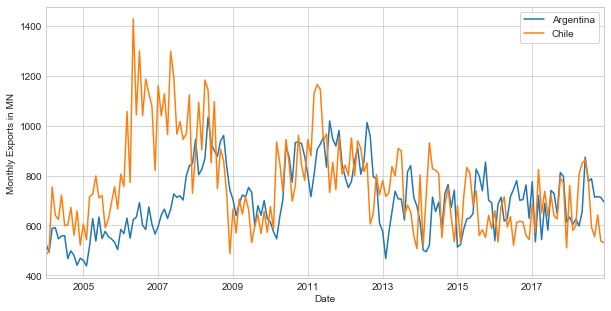

In [183]:
# Visualization for two example partners
plt.figure(figsize=(10,5))
df[df.PARTNER_ISO == "AR"]["IMPORTS_MN"].rename("Argentina")["2004":"2018"].plot()
df[df.PARTNER_ISO == "CL"]["IMPORTS_MN"].rename("Chile")["2004":"2018"].plot()
plt.xlabel("Date")
plt.ylabel("Monthly Exports in MN")
plt.legend(frameon=True)
plt.show()